In [30]:
#Python Default 

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

import pickle
import time
import random

#Essentials

import numpy as np
from bs4 import BeautifulSoup
import requests
import func_timeout
import pandas as pd
from itables import show

#from objproxies import *

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

#Qiskit

from qiskit.circuit import Gate
from qiskit.circuit.library import *
from qiskit import transpile
from qiskit.providers.models import *
from qiskit_ibm_runtime.fake_provider import *
from qiskit.providers.fake_provider import *
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit_aer import StatevectorSimulator

## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.problems import EigenstateResult

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF


## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import VQE as  VQE_algorithms   #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP

from qiskit.circuit.library import EfficientSU2   #EfficientSU2

## Qiskit Estimators

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

from qiskit_ibm_runtime import Estimator 

from qiskit_ibm_runtime import EstimatorV2

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options

## Braket

from braket.tracking import Tracker
from qiskit_braket_provider import *


%matplotlib widget
#%matplotlib inline

## Importando Backends

In [3]:
provider = BraketProvider()
local_simulator = BraketLocalBackend()
sv1 = provider.get_backend("SV1")
aria = provider.get_backend("Aria 1")
harmony = provider.get_backend("Harmony")
statevector_simulator = StatevectorSimulator()

## Problema Principal

In [4]:
driver = PySCFDriver(
    atom= f"H 0 0 0; H 0 0 1",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

#estimator = Estimator(backend = local_simulator, options={"shots" : 2000, "noise_model" : noise_model, "coupling_map" : coupling_map})

estimator = Estimator(backend = local_simulator)

mapper = JordanWignerMapper()

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE_algorithms(estimator, ansatz, COBYLA())

vqe_solver.initial_point = [0.0] * ansatz.num_parameters

calc = GroundStateEigensolver(mapper, vqe_solver)

minimum_eigenvalue = vqe_solver.compute_minimum_eigenvalue(calc.get_qubit_operators(es_problem)[0])

res = calc.solve(es_problem)

resultado_final = res.groundenergy

## Criando o Circuito Principal - Aria1

In [ ]:
circuito = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), aria)

circuito.draw(output = "mpl")

### Análise de Gates

In [ ]:
gates = []

for i, (gate, qubits, etc) in enumerate(circuito.data):
    
    gates.append(gate.name)

set_gates = list(set(gates))

set_gates.sort(key = lambda x: gates.count(x), reverse = True)

print("Gates present: " + " ".join(set_gates), end = "\n\n")
print(f"Number of gates: {len(gates)}\n\nDistribution of gates: \n")

for i in set_gates:
    
    print(i, gates.count(i))

# Definindo Funções

## Método 1 - Original

In [46]:
def salvar(a):
    with open(f'AWS/Gabriel/GroundState2/dados/{a}.pickle', 'wb') as f:
        pickle.dump(eval(a), f) 

def abrir(a):
    with open(f'AWS/Gabriel/GroundState2/dados/{a}.pickle', 'rb') as f:
        return pickle.load(f)
    
def clifford_gate():

   random_value = random.randint(0, 3)
   
   return RZGate(random_value*np.pi/2)

def subs_ncg(quantum_circuit, n):
    
   quantum_circuit = quantum_circuit.copy()

   n = int(n * quantum_circuit.size())

   non_permitted_gates = ["cx"]

   gates_to_change = random.sample(range(0, quantum_circuit.size()+1), n)

   for i, (gate, *qubits) in enumerate(quantum_circuit.data):
      
      if i in gates_to_change:
      
         if gate.name not in non_permitted_gates:
            
            quantum_circuit.data[i] = (clifford_gate(), *qubits)

         else:
            
            new_gate = random.randint(i, len(quantum_circuit.data)-1)
            
            #while quantum_circuit.data[new_gate][0].name in non_permitted_gates or new_gate in gates_to_change:
            while quantum_circuit.data[new_gate][0].name in non_permitted_gates:
                
                new_gate = random.randint(i, len(quantum_circuit.data)-1)

            quantum_circuit.data[new_gate] = (clifford_gate(), *quantum_circuit.data[new_gate][1:])

   return quantum_circuit

def run_statevector(circuit, driver, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   estado = Statevector.from_instruction(circuit)
   
   expectation_value = estado.expectation_value(mapper.map(hamiltoniano))
   
   return expectation_value.real

def run_estimator(circuit, driver_, backend, shots = 2000, noise_model = None, coupling_map = None, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver_.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   if noise_model is not None:
      
      estimator = Estimator(backend = backend, options = {"shots" : shots, "noise_model" : noise_model, "coupling_map" : coupling_map})
   
   else :
      
      estimator = Estimator(backend = backend, options = {"shots" : shots})
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer(circuit, driver_, shots = 2000, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True):
   
   hamiltoniano = driver_.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   if seed is not None:
      
      estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)   
   
   else :
      
      estimator = Estimator_Aer(run_options = {"shots" : shots}, skip_transpilation = skip_transpilation)
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def check (original_value, target, driver, difference_percentage, run_statevector_ = True, backend = None, shots = 2000, noise_model = None, coupling_map = None, mapper = JordanWignerMapper()):
   
   if run_statevector_:
      target = run_statevector(target, driver)
   
   else:
      target = run_estimator(target, driver, backend, shots, noise_model, coupling_map, mapper)
   
   return abs(original_value - target) < difference_percentage * abs(original_value), target

def modelo_1(original_circuit, number_of_circuits, driver, percentage_of_changed_gates = 0.3, difference_percentage = 0.5, do_check = True, run_statevector_ = True, backend = None, shots = 2000, noise_model = None, coupling_map = None, mapper = JordanWignerMapper()):
   
   original_circuit_exp_value = run_statevector(original_circuit, driver)
   
   while number_of_circuits > 0:
      
      new_circuit = subs_ncg(original_circuit, percentage_of_changed_gates)
      
      if do_check:
      
         if run_statevector_ :
            
            check_result = check(original_circuit_exp_value, new_circuit, driver, difference_percentage)
            
         else :
            
            check_result = check(original_circuit_exp_value, new_circuit, driver, difference_percentage, run_statevector_ = False, backend = backend, shots = shots, noise_model = noise_model, coupling_map = coupling_map, mapper = mapper)
         
         if check_result[0] :
         
            number_of_circuits -= 1
         
            yield new_circuit, check_result[1]
         
      else :
         
         number_of_circuits -= 1
         
         yield new_circuit

   

## Método 1 - Update

In [6]:
def salvar(a):
    with open(f'AWS/Gabriel/GroundState2/dados/{a}.pickle', 'wb') as f:
        pickle.dump(eval(a), f) 

def abrir(a):
    with open(f'AWS/Gabriel/GroundState2/dados/{a}.pickle', 'rb') as f:
        return pickle.load(f)
    
def clifford_gate():

   random_value = random.randint(0, 3)
   
   return RZGate(random_value*np.pi/2)

def subs_ncg(quantum_circuit, n):
    
   quantum_circuit = quantum_circuit.copy()

   n = int(n * quantum_circuit.size())

   non_permitted_gates = ["cx"]

   gates_to_change = random.sample(range(0, quantum_circuit.size()+1), n)

   for i, (gate, *qubits) in enumerate(quantum_circuit.data):
      
      if i in gates_to_change:
      
         if gate.name not in non_permitted_gates:
            
            quantum_circuit.data[i] = (clifford_gate(), *qubits)

         else:
            
            new_gate = random.randint(i, len(quantum_circuit.data)-1)
            
            #while quantum_circuit.data[new_gate][0].name in non_permitted_gates or new_gate in gates_to_change:
            while quantum_circuit.data[new_gate][0].name in non_permitted_gates:
                
                new_gate = random.randint(i, len(quantum_circuit.data)-1)

            quantum_circuit.data[new_gate] = (clifford_gate(), *quantum_circuit.data[new_gate][1:])

   return quantum_circuit

def run_statevector(circuit, driver, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   estado = Statevector.from_instruction(circuit)
   
   expectation_value = estado.expectation_value(mapper.map(hamiltoniano))
   
   return expectation_value.real

def run_estimator(circuit, driver, backend = None, shots = 2000, noise_model = None, coupling_map = None, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   if noise_model is not None:
      
      estimator = Estimator(backend = backend, options = {"shots" : shots, "noise_model" : noise_model, "coupling_map" : coupling_map})
   
   else :
      
      estimator = Estimator(backend = backend, options = {"shots" : shots})
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer(circuit, driver, shots = 0, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   if seed is not None:
      
      estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)   
   
   else :
      
      estimator = Estimator_Aer(run_options = {"shots" : shots}, skip_transpilation = skip_transpilation)
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]


ESTIMATORS = {
    'statevector': run_statevector,
    'estimator': run_estimator,
    'estimator_aer': run_estimator_aer,
}

def check(original_value, target, driver, difference_percentage, estimator_name='statevector', **kwargs):
    estimator_function = ESTIMATORS[estimator_name]
    target_value = estimator_function(target, driver, **kwargs)
    return abs(original_value - target_value) < difference_percentage * abs(original_value), target_value

def modelo_1(original_circuit, number_of_circuits, driver, percentage_of_changed_gates=0.3, difference_percentage=0.5, do_check=True, estimator_name='statevector', **kwargs):
    original_circuit_exp_value = run_statevector(original_circuit, driver)
    
    while number_of_circuits > 0:
        new_circuit = subs_ncg(original_circuit, percentage_of_changed_gates)
        
        if do_check:
            check_result, target_value = check(original_circuit_exp_value, new_circuit, driver, difference_percentage, estimator_name=estimator_name, **kwargs)
            if check_result:
                number_of_circuits -= 1
                yield new_circuit, target_value
        else:
            number_of_circuits -= 1
            yield new_circuit
   

## Teste

In [ ]:
hamiltoniano = es_problem.second_q_ops()[0]

num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
num_qubits_circuit = circuito.num_qubits

new_circuit = QuantumCircuit(num_qubits_hamiltonian)

for gate in circuito.data:

    if all(circuito.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
        
        new_circuit.append(gate[0], [circuito.qubits.index(qubit) for qubit in gate[1]])
        
new_circuit.draw(output = "mpl")

In [ ]:
circuito = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), aria)

circuito.num_qubits

In [ ]:
run_estimator(circuito, es_problem, local_simulator, shots=0)

In [47]:
for a in range(1, 2000, 100):

    print("--------------------------")
    print(a)
    print(f"Estimator V1: {run_estimator(circuito, es_problem, statevector_simulator, shots=a)}\nEstimator Aer: {run_estimator_aer(circuito, es_problem)}")
    print("--------------------------")

--------------------------
1
Estimator V1: -1.496890568495202
Estimator Aer: -1.6321963155519335
--------------------------
--------------------------
101
Estimator V1: -1.651542057663922
Estimator Aer: -1.6225530505446164
--------------------------
--------------------------
201
Estimator V1: -1.6243448429072165
Estimator Aer: -1.6303206882041201
--------------------------
--------------------------
301
Estimator V1: -1.6171434707315648
Estimator Aer: -1.6228411866260457
--------------------------
--------------------------
401
Estimator V1: -1.636935790907967
Estimator Aer: -1.6255598745206232
--------------------------
--------------------------
501
Estimator V1: -1.6372603241159578
Estimator Aer: -1.6239140141745247
--------------------------
--------------------------
601
Estimator V1: -1.6413481610015161
Estimator Aer: -1.6287830930373026
--------------------------
--------------------------
701
Estimator V1: -1.6296849599246612
Estimator Aer: -1.6298537913993216
----------------

In [10]:
# Testando o tempo de computação de cada estimator

# Criando 100 circuitos sem o check para testar o tempo de computação

circuitos = [i for i in modelo_1(circuito, 100, es_problem, do_check = False)]

original_circuit_exp_value = run_statevector(circuito, es_problem)

valores_esperados_statevector = []
valores_esperados_estimator = []
valores_esperados_estimator_aer = []

for circuito_ in circuitos:

    t = time.time()
    valor_esperado = run_statevector(circuito_, es_problem)
    t = time.time() - t
    valores_esperados_statevector.append((valor_esperado, t))

    t = time.time()
    valor_esperado = run_estimator(circuito_, es_problem, local_simulator, shots = 2000)
    t = time.time() - t
    valores_esperados_estimator.append((valor_esperado, t))
    
    t = time.time()
    valor_esperado = run_estimator_aer(circuito_, es_problem, seed = 0)
    t = time.time() - t
    valores_esperados_estimator_aer.append((valor_esperado, t))

print("--------------------------")

print(f"Statevector : {sum([i[1] for i in valores_esperados_statevector])}")
print(f"Estimator : {sum([i[1] for i in valores_esperados_estimator])}")
print(f"Estimator Aer : {sum([i[1] for i in valores_esperados_estimator_aer])}")

--------------------------
Statevector : 3024.2025389671326
Estimator : 27.30417227745056
Estimator Aer : 8.907607793807983


# Criando QC - Modelo 1

In [13]:
modelo = modelo_1(circuito, 1000, es_problem, percentage_of_changed_gates = 0.3, difference_percentage = 0.3, do_check=True, estimator_name = "estimator_aer", seed = 1)

circuitos_similares = []

time_total, start_time = time.time(), time.time()

for index, i in enumerate(modelo):

    end_time = time.time() - start_time

    circuitos_similares.append(i)
    print(f"Iteração {index}: {end_time}s")

    start_time = time.time()
    
print(f"Tempo total: {time.time() - time_total}")

Iteração 0: 37.244240283966064s
Iteração 1: 2.235135793685913s
Iteração 2: 0.0657494068145752s
Iteração 3: 2.179933786392212s
Iteração 4: 8.417949914932251s
Iteração 5: 1.935347557067871s
Iteração 6: 8.743247985839844s
Iteração 7: 3.5827198028564453s
Iteração 8: 1.590172529220581s
Iteração 9: 2.8713293075561523s
Iteração 10: 12.812959671020508s
Iteração 11: 0.4983546733856201s
Iteração 12: 1.3814575672149658s
Iteração 13: 0.6350736618041992s
Iteração 14: 9.88228726387024s
Iteração 15: 13.412488222122192s
Iteração 16: 2.709258556365967s
Iteração 17: 0.3445580005645752s
Iteração 18: 0.2265489101409912s
Iteração 19: 4.48053503036499s
Iteração 20: 1.7988255023956299s
Iteração 21: 2.966994524002075s
Iteração 22: 1.9325275421142578s
Iteração 23: 0.06677460670471191s
Iteração 24: 10.95442247390747s
Iteração 25: 0.5408074855804443s
Iteração 26: 2.418013334274292s
Iteração 27: 0.7570950984954834s
Iteração 28: 0.20618081092834473s
Iteração 29: 2.9946446418762207s
Iteração 30: 2.6056008338928223s

In [14]:
salvar("circuitos_similares")

In [15]:
circuitos_aria_3030_aer = abrir("circuitos_similares")

In [16]:
salvar("circuitos_aria_3030_aer")

## Análise QC

In [25]:
original_expectation_value = run_estimator_aer(circuito, es_problem, seed = 1)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito.data if g.name == gate.name) for gate, *_ in circuito.data}

original_circuit_dict = {
    'circuit': hex(id(circuito)),
    'num_gates': circuito.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expected_value': original_expectation_value,
    'percentage_difference (%)': 0.00
}

data = [original_circuit_dict]

for a in circuitos_aria_3030_aer:
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expected_value'] = expetation_value
    row['percentage_difference (%)'] = abs(abs(expetation_value - original_expectation_value) / original_expectation_value)* 100

df = pd.DataFrame(data)

df

,circuit,num_gates,gate_counts,changed_gates,rz_gates,expected_value,percentage_difference (%)
0,0x7f5145f8f590,102,"{'cx': 56, 'rx': 23, 'rz': 14, 'h': 6, 'ry': 2...","{'rz': 0, 'ry': 0, 'h': 0, 'cx': 0, 'rx': 0, '...",14,-1.635294,0.000000
1,0x7f5144842600,102,"{'cx': 56, 'rz': 30, 'rx': 11, 'h': 3, 'ry': 2}","{'rz': 16, 'cx': 0, 'ry': 0, 's': -1, 'h': -3,...",30,-1.145094,29.976280
2,0x7f51469d7380,102,"{'cx': 56, 'rz': 32, 'rx': 9, 'h': 4, 'ry': 1}","{'rz': 18, 'cx': 0, 'ry': -1, 's': -1, 'h': -2...",32,-1.141882,30.172699
3,0x7f509dac0e60,102,"{'cx': 56, 'rz': 30, 'rx': 12, 'h': 2, 'ry': 1...","{'rz': 16, 'cx': 0, 's': 0, 'ry': -1, 'h': -4,...",30,-1.283680,21.501589
4,0x7f509dac18e0,102,"{'cx': 56, 'rz': 28, 'rx': 12, 'h': 3, 'ry': 2...","{'rz': 14, 'cx': 0, 'ry': 0, 's': 0, 'h': -3, ...",28,-1.288501,21.206757
...,...,...,...,...,...,...,...
996,0x7f50726d2e10,102,"{'cx': 56, 'rz': 32, 'rx': 12, 'h': 2}","{'rz': 18, 'cx': 0, 's': -1, 'ry': -2, 'h': -4...",32,-1.236469,24.388607
997,0x7f50726f1310,102,"{'cx': 56, 'rz': 31, 'rx': 12, 'h': 2, 'ry': 1}","{'rz': 17, 'cx': 0, 'ry': -1, 's': -1, 'h': -4...",31,-1.282581,21.568812
998,0x7f50726f37d0,102,"{'cx': 56, 'rz': 28, 'rx': 15, 'h': 3}","{'rz': 14, 'cx': 0, 's': -1, 'ry': -2, 'h': -3...",28,-1.142214,30.152367
999,0x7f5072505ca0,102,"{'cx': 56, 'rz': 32, 'rx': 10, 'ry': 2, 'h': 1...","{'rz': 18, 'cx': 0, 'ry': 0, 's': 0, 'h': -5, ...",32,-1.142828,30.114859


In [32]:
show(df)

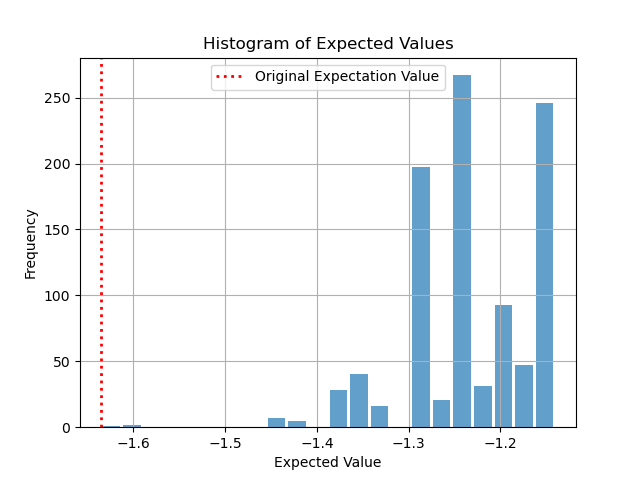

In [22]:
expected_values = df['expected_value']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.axvline(original_expectation_value, color='r', linestyle='dotted', linewidth=2, label='Original Expectation Value')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Values')
plt.legend()
plt.grid(True)

plt.show()

# Simulando Aria 1

# Rodando em na AWS